In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller, kpss
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense, LSTM
from keras.models import Sequential, load_model
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
df = pd.read_csv('data/usd_rub.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index("Date")

<Axes: xlabel='Date'>

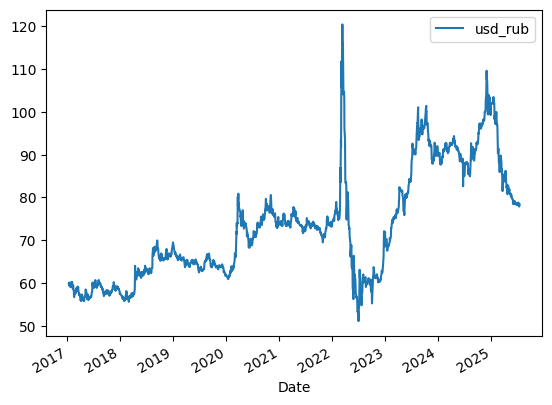

In [3]:
df.plot()

<Axes: xlabel='Date'>

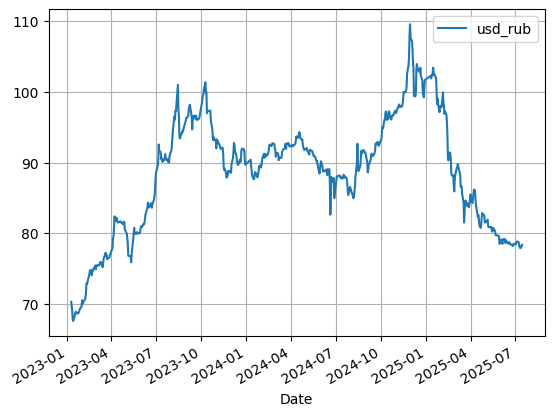

In [4]:
df_cut = df.loc['2023-01-01':]
df_cut.plot(grid=True)

Очистка данных

In [5]:
def find_anomaly(data_value, window_mean):
    diff = abs(data_value - window_mean) / data_value
    return(diff > 0.1)

In [6]:
w = 7
windows = df_cut.rolling(w).mean()
windows.dropna(inplace = True)
df_clear = pd.DataFrame(columns=['usd_rub'])
for date in windows.index:
    if find_anomaly(df_cut.loc[date, 'usd_rub'], windows.loc[date, 'usd_rub']):
        df_clear.loc[date] = windows.loc[date]
    else:
        df_clear.loc[date] = df_cut.loc[date]
df_clear

,usd_rub
2023-01-18,68.6644
2023-01-19,68.8728
2023-01-20,68.8467
2023-01-21,68.6656
2023-01-24,68.6288
...,...
2025-07-09,78.1682
2025-07-10,78.1727
2025-07-11,77.9029
2025-07-12,77.8855


<Axes: >

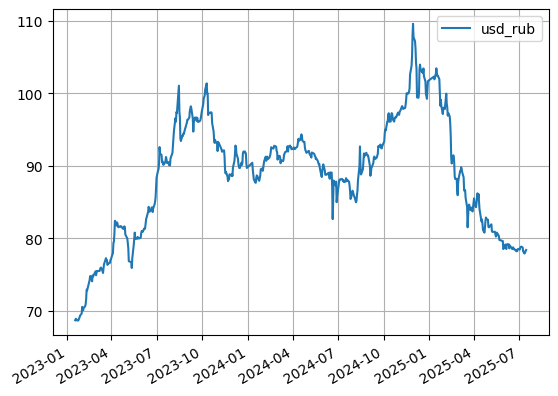

In [7]:
df_clear.plot(grid=True)

LSTM

Оценка автокорреляции, чтобы оценить размер окна.

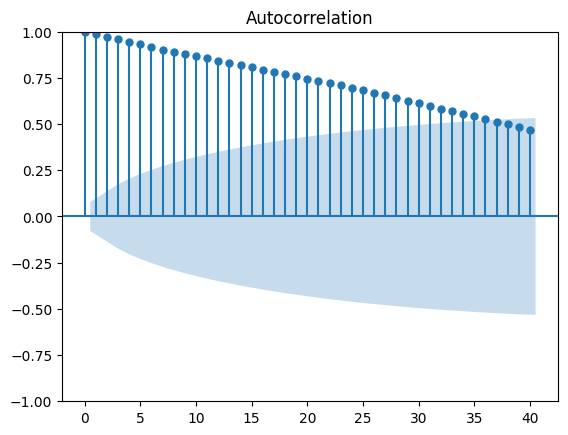

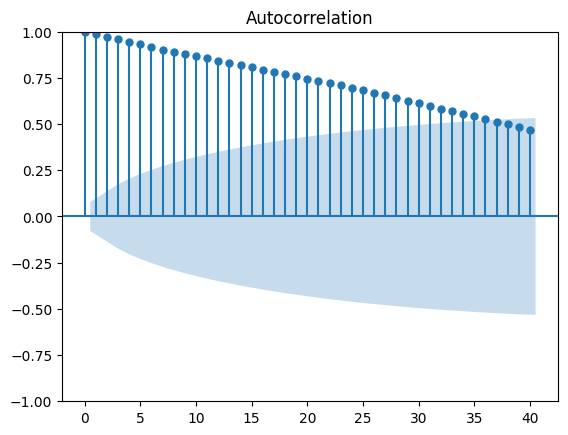

In [8]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df_clear['usd_rub'], lags=40)

In [11]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[['usd_rub']])

In [12]:
def create_sequences(data, n_steps):
    x, y = [], []
    for i in range(len(data) - n_steps):
        x.append(data[i:i + n_steps])
        y.append(data[i + n_steps])
    return np.array(x), np.array(y)

n_steps = 36
x, y = create_sequences(scaled, n_steps)

In [13]:
cutoff_date = '2025-01-10' # первый рабочий день в январе
cutoff_index = df.index.get_loc(cutoff_date)

x_train = x[:cutoff_index - n_steps]
y_train = y[:cutoff_index - n_steps]
x_test = x[cutoff_index - n_steps:]
y_test = y[cutoff_index - n_steps:]
test_dates = df.index[cutoff_index:]

In [14]:
model = Sequential([
    LSTM(50, activation='relu', input_shape=(x_train.shape[1], 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
history = model.fit(
    x_train, y_train,
    epochs=50,
    batch_size=16,
    validation_data=(x_test, y_test),
    verbose=1
)

Epoch 1/50


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0318 - val_loss: 0.0015
Epoch 2/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0012 - val_loss: 6.2299e-04
Epoch 3/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0011 - val_loss: 4.5723e-04
Epoch 4/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.0416e-04 - val_loss: 8.3937e-04
Epoch 5/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.7784e-04 - val_loss: 4.7001e-04
Epoch 6/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.4827e-04 - val_loss: 4.2298e-04
Epoch 7/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.5639e-04 - val_loss: 7.1268e-04
Epoch 8/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.1188e-04 - val_loss: 4.3146e-04
Epoch 9/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.4666e-04 - val_loss: 5.5381e-04
Epoch 10/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.9948e-04 - val_loss: 3.6860e-04
Epoch 11/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.1497e-04 - val_loss: 3.

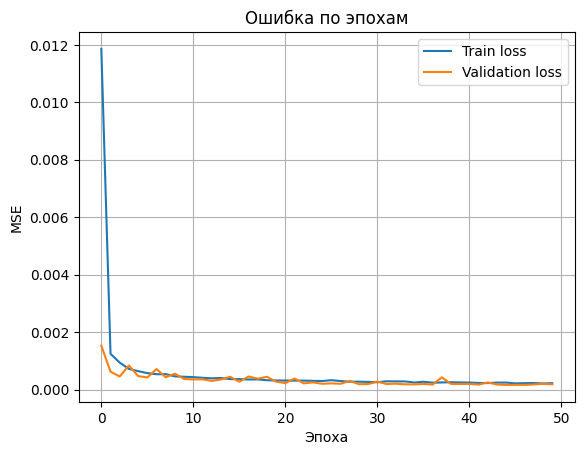

In [15]:
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Ошибка по эпохам')
plt.xlabel('Эпоха')
plt.ylabel('MSE')
plt.legend()
plt.grid()
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


<Axes: title={'center': 'Прогноз LSTM vs фактический курс'}, xlabel='Дата', ylabel='Курс'>

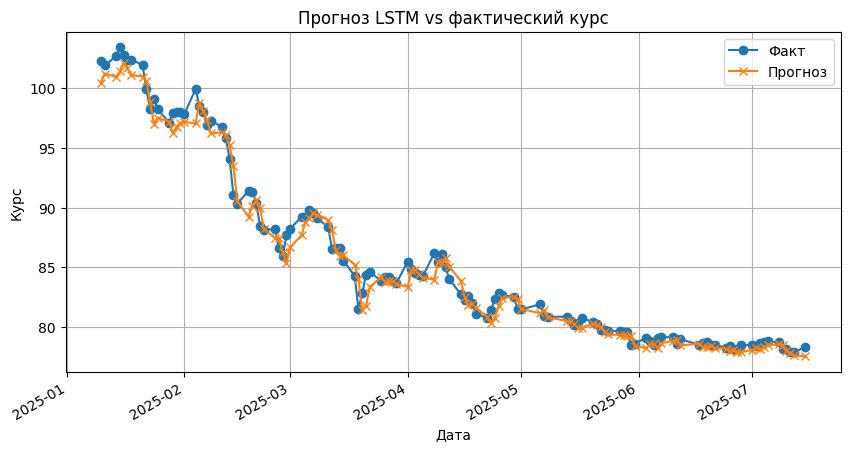

In [16]:
y_pred_scaled = model.predict(x_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_true = scaler.inverse_transform(y_test)

df_result = pd.DataFrame({
    'Дата': test_dates,
    'Факт': y_true.flatten(),
    'Прогноз': y_pred.flatten()
}).set_index('Дата')

df_result.plot(
    figsize=(10, 5),
    title='Прогноз LSTM vs фактический курс',
    style={'Факт': 'o-', 'Прогноз': 'x-'},
    ylabel='Курс',
    grid = True
)

In [17]:
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f'MAE: {mae:.4f}')
print(f'RMSE: {rmse:.4f}')

MAE: 0.6754
RMSE: 0.9416
